In [1]:
import pandas as pd
import numpy as np
import random as rd 
import pickle as pk
import matplotlib.pyplot as plt

from Judge.Score import *   # 评价指标

In [2]:
df_ft = pd.read_csv('./Datasets/train_feature.csv')
df_lb = pd.read_csv('./Datasets/train_label.csv') 
ori_df = pd.concat([df_ft, df_lb], axis=1)


## 数据预处理
首先进行数据的预处理。

In [3]:
from Preprocessing import Tools as M_TOOL

def Preprocess(df: pd.DataFrame, method='method 1'):
    # df.fillna(df.median(), inplace=True)

    df.fillna(method = 'bfill')
    df.fillna(method = 'ffill')
    df.fillna(df.median(), inplace=True)
    
    if method == 'method 1':
        df = M_TOOL.Drop_noise(df)
        
    elif method == 'method 2':
        df = M_TOOL.Drop_noise_data(df, if_debug=True, min_delta=1e-1, iter_times=50)
        
    elif method == 'method 3':
        pure_df = M_TOOL.Drop_noise_data(df, if_debug=True, min_delta=1e-1, iter_times=50)
        df = M_TOOL.Fix_Noise_data(df, pure_df, if_debug=True)
        
    elif method == 'method 4':
        pure_df = M_TOOL.Drop_noise(df)
        df = M_TOOL.Fix_Noise_data(df, pure_df, if_debug=True)
        
    df = M_TOOL.Normalization(df, if_debug=True)
    df = M_TOOL.Delete_feature(df)
    return df


df = Preprocess(ori_df, method='method 3')
print(df.shape)

(10000, 13)


## 模型训练与预测

接下来，我们将分别使用线性回归模型、决策树模型、神经网络模型、支持向量机以及 XGBoost 等分类模型对数据集进行训练，并在验证集上进行预测。

In [4]:
from Methods import LinearReg as M_LR
# 线性回归模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

model_liner = M_LR.LinearRegression(X_train, y_train)
model_liner.fit()
pre = model_liner.predict(X_test)
acc = Accuracy(pre, y_test)
print("线性回归模型分类准确度为 {}".format(acc))


# 与 Sklearn 比较
from sklearn.linear_model import LinearRegression as LR  
model_liner_skl = LR().fit(X_train, y_train)
pre_skl = model_liner_skl.predict(X_test)
acc = Accuracy(pre_skl, y_test)
print("SKLearn 线性回归模型分类准确度为 {}".format(acc))


线性回归模型分类准确度为 0.2550979608156737
SKLearn 线性回归模型分类准确度为 0.25029988004798076


In [5]:
from Methods import DecTree as M_DTC


parameters = {
    "criterion": "entropy",       # 选择特征的标准，分为 "gini" 和 "entropy"
    "splitter": "best",        # 特征划分标准，分为 "best" 和 "random"
    "max_depth": 8,
    "min_samples_split": 2,   
    "min_samples_leaf": 4,    
    "max_leaf_nodes": 100000,   
    "min_impurity_decrease": 0.0, 
    "if_silent": 1
}

def my_sort(t1):
    return t1[2]

acc_list = []
N=1
for depth in range(1, 45):
    for m_leaf in range(1, 45):
    
        parameters['max_depth'] = depth
        parameters['min_samples_leaf'] = m_leaf 
        acc_sum = 0
        
        for times in range (1, N+1):
        
            X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)     # 3.5 sigma 1e-1 50
            model_dtc = M_DTC.DecisionTree(X_train, y_train)
            model_dtc.fit(parameters)

            pre = model_dtc.predict(X_test)
            pre = np.array(pre).reshape(-1, 1)
            acc_sum += Accuracy(pre, y_test)
            
        acc_list.append((depth, m_leaf, acc_sum/N))
        
        acc_list.sort(key = my_sort, reverse=True)
        test = pd.DataFrame(data=acc_list)
        test.to_csv("./debug/dec_tree_params_3.csv",encoding='gbk')
    


KeyboardInterrupt: 

In [190]:
# 决策树模型
from Methods import DecTree as M_DTC
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)     #0.7，  1

parameters = {
    "criterion": "gini",       # 选择特征的标准，分为 "gini" 和 "entropy"
    "splitter": "best",        # 特征划分标准，分为 "best" 和 "random"
    "max_depth": 14,
    "min_samples_split": 2,   
    "min_samples_leaf": 17,    
    "max_leaf_nodes": 100000,   
    "min_impurity_decrease": 0.0, 
    "if_silent": 1
}

model_dtc = M_DTC.DecisionTree(X_train, y_train)
model_dtc.fit(parameters)
# model_dtc.save("./model/Model_DecTree_0.29")

pre = model_dtc.predict(X_test)
pre = np.array(pre).reshape(-1, 1)


acc_dtc = Accuracy(pre, y_test)
print("决策树分类准确度为 {}".format(acc_dtc))


决策树分类准确度为 0.2951977401129944


SVM (01) 模型分类准确度为 0.5205479452054795
SVM (02) 模型分类准确度为 0.5154061624649859
SVM (03) 模型分类准确度为 0.519774011299435
SVM (12) 模型分类准确度为 0.5112994350282486
SVM (13) 模型分类准确度为 0.5128205128205128
SVM (23) 模型分类准确度为 0.4985422740524781
SVM 模型分类准确度为 0.268361581920904


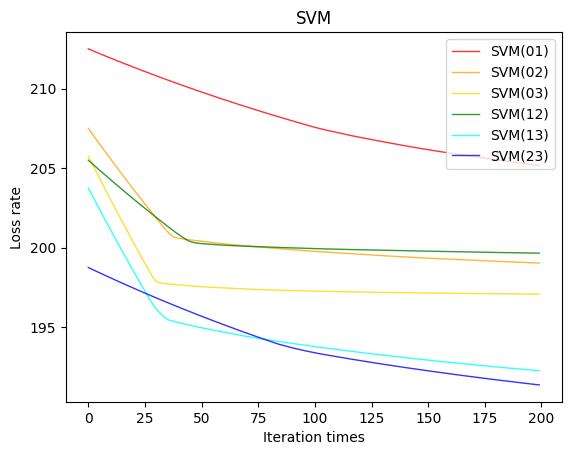

In [38]:
from Methods import SVM as M_SVM
# 支持向量机模型

def show(times, loss, color = '#4169E1', start=0, end=2000, title = ""):
    x_axis_data = list(range(times + 1))[start:end]
    y_axis_data = loss[start:end]
    plt.title(title)
    plt.plot(x_axis_data, y_axis_data, color=color, alpha=0.8, linewidth=1)

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 1], rate=0.7)
model_SVM_01 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_01.fit(max_times=200, ifsilent=True)
pre_01 = model_SVM_01.predict(X_test)
acc_01 = Accuracy(pre_01, y_test)
print("SVM (01) 模型分类准确度为 {}".format(acc_01))
show(times, loss, color='RED')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 2], rate=0.7)
model_SVM_02 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_02.fit(max_times=200, ifsilent=True)
pre_02 = model_SVM_02.predict(X_test)
acc_02 = Accuracy(pre_02, y_test)
print("SVM (02) 模型分类准确度为 {}".format(acc_02))
show(times, loss, color='ORANGE')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [0, 3], rate=0.7)
model_SVM_03 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_03.fit(max_times=200, ifsilent=True)
pre_03 = model_SVM_03.predict(X_test)
acc_03 = Accuracy(pre_03, y_test)
print("SVM (03) 模型分类准确度为 {}".format(acc_03))
show(times, loss, color='GOLD')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [1, 2], rate=0.7)
model_SVM_12 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_12.fit(max_times=200, ifsilent=True)
pre_12 = model_SVM_12.predict(X_test)
acc_12 = Accuracy(pre_12, y_test)
print("SVM (12) 模型分类准确度为 {}".format(acc_12))
show(times, loss, color='GREEN')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [1, 3], rate=0.7)
model_SVM_13 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_13.fit(max_times=200, ifsilent=True)
pre_13 = model_SVM_13.predict(X_test)
acc_13 = Accuracy(pre_13, y_test)
print("SVM (13) 模型分类准确度为 {}".format(acc_13))
show(times, loss, color='CYAN')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, [2, 3], rate=0.7)
model_SVM_23 = M_SVM.SupportVectorMachine(X_train, y_train)
loss, times = model_SVM_23.fit(max_times=200, ifsilent=True)
pre_23 = model_SVM_23.predict(X_test)
acc_23 = Accuracy(pre_23, y_test)
print("SVM (23) 模型分类准确度为 {}".format(acc_23))
show(times, loss, title="SVM", color='BLUE')

plt.legend(['SVM(01)', 'SVM(02)', 'SVM(03)', 'SVM(12)', 'SVM(13)', 'SVM(23)'], loc='upper right')
plt.xlabel('Iteration times')
plt.ylabel('Loss rate')

X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)
pre_01 = model_SVM_01.predict(X_test)
pre_02 = model_SVM_02.predict(X_test)
pre_03 = model_SVM_03.predict(X_test)
pre_12 = model_SVM_12.predict(X_test)
pre_13 = model_SVM_13.predict(X_test)
pre_23 = model_SVM_23.predict(X_test)

m, _ = X_test.shape
pre_svm = np.zeros((m, 1))

for i in range(0, m):
    vote = [0, 0, 0, 0]
    vote[int(pre_01[i, 0])] += 1
    vote[int(pre_02[i, 0])] += 1
    vote[int(pre_03[i, 0])] += 1
    vote[int(pre_12[i, 0])] += 1
    vote[int(pre_13[i, 0])] += 1
    vote[int(pre_23[i, 0])] += 1
    pre_svm[i, 0] = vote.index(max(vote))
    

acc_svm = Accuracy(pre_svm, y_test)
print("SVM 模型分类准确度为 {}".format(acc_svm))

In [46]:
from Methods import NeuralNet as M_NN
# 神经网络模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

parameters = {
    "hidden_layer_sizes": (5, 10, 5),
    "activation": 'relu', # 激活函数, ‘identity’，‘logistic’，‘tanh’，‘relu’
    "alpha": 0.0003, # 可选，默认为0.0001。L2惩罚（正则化项）参数。
    "max_iter": 200, # 默认值200。最大迭代次数。solver迭代直到收敛（由’tol’确定）或这个迭代次数。对于随机解算器（‘sgd’，‘adam’），请注意，这决定了时期的数量（每个数据点的使用次数），而不是梯度步数。
    "tol": 1e-3, # 默认1e-4 优化的容忍度，容差优化。当n_iter_no_change连续迭代的损失或分数没有提高至少tol时，除非将learning_rate设置为’adaptive’，否则认为会达到收敛并且训练停止。
    "if_silent": True, 
    "early_stopping": True, # 当验证评分没有改善时，是否使用提前停止来终止培训。如果设置为true，它将自动留出10％的训练数据作为验证，并在验证得分没有改善至少为n_iter_no_change连续时期的tol时终止训练。仅在solver ='sgd’或’adam’时有效
    "validation_fraction": 0.1, # 将训练数据的比例留作早期停止的验证集。必须介于0和1之间。仅在early_stopping为True时使用
}

model_NN = M_NN.NeuralNetwork(X_train, y_train)
model_NN.fit(parameters)
# model_NN.save("./model/Model_NN_0.258")
pre = model_NN.predict(X_test)
pre = np.array(pre).reshape(-1, 1)

acc_NN = Accuracy(pre, y_test)
print("神经网络模型分类准确度为 {}".format(acc_NN))

神经网络模型分类准确度为 0.24950019992003203


d:\Python\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
from Methods import XGBoost as M_XGB
# XGBoost 模型
X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df)

parameters = {
    "learning_rate": 0.3,       # 如同学习率
    "min_child_weight": 1, 
    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
    #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
    "max_depth": 10,             # 构建树的深度，越大越容易过拟合
    "gamma": 0,                 # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
    "subsample": 1,             # 随机采样训练样本 训练实例的子采样比
    "max_delta_step": 0,        # 最大增量步长，我们允许每个树的权重估计。
    "colsample_bytree": 1,      # 生成树时进行的列采样 
    "reg_lambda": 1,            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    "reg_alpha": 0,             # L1 正则项参数
    "objective": 'multi:softmax',   # 多分类的问题 指定学习任务和相应的学习目标 binary:logitraw   multi:softmax
    "num_class": 4,             # 类别数
    "n_estimators": 20,         # 树的个数
    "seed": 2000,                # 随机种子     
    "if_silent": 1,
}

model_XGB = M_XGB.XGBoost(X_train, y_train)
model_XGB.fit(parameters)
# model_XGB.save("./model/Model_XGBoost_0.28")
# model_XGB= pk.load(open("./model/Model_XGBoost_0.28", "rb")) 

pre = model_XGB.predict(X_test)
pre = np.array(pre).reshape(-1, 1)

acc_xgb = Accuracy(pre, y_test)
print("XGBoost 模型分类准确度为 {}".format(acc_xgb))


XGBoost 模型分类准确度为 0.22990803678528593


In [53]:
from Methods import XGBoost as M_XGB
# XGBoost 模型

parameters = {
    "learning_rate": 0.3,       # 如同学习率
    "min_child_weight": 1, 
    # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
    #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
    # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
    "max_depth": 16,             # 构建树的深度，越大越容易过拟合
    "gamma": 0,                 # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
    "subsample": 1,             # 随机采样训练样本 训练实例的子采样比
    "max_delta_step": 0,        # 最大增量步长，我们允许每个树的权重估计。
    "colsample_bytree": 1,      # 生成树时进行的列采样 
    "reg_lambda": 1,            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
    "reg_alpha": 0,             # L1 正则项参数
    "objective": 'multi:softmax',   # 多分类的问题 指定学习任务和相应的学习目标 binary:logitraw   multi:softmax
    "num_class": 4,             # 类别数
    "n_estimators": 20,         # 树的个数
    "seed": 2000,                # 随机种子     
    "if_silent": 1,
}

def my_sort(t1):
    return t1[2]

acc_list = []
N=1
for depth in range(1, 50):
    for t in range(10, 100, 5):
    
        parameters['max_depth'] = depth
        parameters['n_estimators'] = t 
        acc_sum = 0
        
        for times in range (1, N+1):
        
            X_train, y_train, X_test, y_test = M_TOOL.random_Split_Data_Label(df, rate=0.7)
            model_XGB = M_XGB.XGBoost(X_train, y_train)
            model_XGB.fit(parameters)

            pre = model_XGB.predict(X_test)
            pre = np.array(pre).reshape(-1, 1)
            acc_sum += Accuracy(pre, y_test)
            
        acc_list.append((depth, t, acc_sum/N))
        
        acc_list.sort(key = my_sort, reverse=True)
        test = pd.DataFrame(data=acc_list)
        test.to_csv("./debug/xgb_params_2.csv",encoding='gbk')
    



In [ ]:
# parameters = {
#     "learning_rate": 0.3,       # 如同学习率
#     "min_child_weight": 1, 
#     # 这个参数默认是 1，是每个叶子里面 h 的和至少是多少，对正负样本不均衡时的 0-1 分类而言
#     #，假设 h 在 0.01 附近，min_child_weight 为 1 意味着叶子节点中最少需要包含 100 个样本。
#     # 这个参数非常影响结果，控制叶子节点中二阶导的和的最小值，该参数值越小，越容易 overfitting。
#     "max_depth": 9,             # 构建树的深度，越大越容易过拟合
#     "gamma": 0,                 # 树的叶子节点上作进一步分区所需的最小损失减少,越大越保守，一般0.1、0.2这样子。
#     "subsample": 1,             # 随机采样训练样本 训练实例的子采样比
#     "max_delta_step": 0,        # 最大增量步长，我们允许每个树的权重估计。
#     "colsample_bytree": 1,      # 生成树时进行的列采样 
#     "reg_lambda": 1,            # 控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。
#     "reg_alpha": 0,             # L1 正则项参数
#     "objective": 'multi:softmax',   # 多分类的问题 指定学习任务和相应的学习目标 binary:logitraw   multi:softmax
#     "num_class": 4,             # 类别数
#     "n_estimators": 90,         # 树的个数
#     "seed": 2000,                # 随机种子     
#     "if_silent": 1,
# }


## 最终的预测